In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
import sys
from tqdm import tqdm
sys.path.append("../../../..")
from datasets.morpho_mnist.dataset import ImageDataset, MetadataDataset, TripletDataset
from auto_localization.models.BasicVAE import BasicVAE
from auto_localization.dataset_management.data_manager import DataManager
from auto_localization.plotting.localization import save_localization_metadata_distance_plots
from auto_localization.oracles.metadata_oracle import MetadataOracle
from datasets.morpho_mnist.measure import measure_image
from auto_localization.localization.localization_experiment_manager import LocalizationExperimentManager
from auto_localization.plotting.localization import embedding_with_posterior_path, embedding_with_planes, save_localization_metadata_distance_plots
import auto_localization.plotting.localization as localization_plotting
import auto_localization.plotting.image_sampling as image_sampling
from auto_localization.localization.localizers.active_localization import pair2hyperplane, KNormalizationType

In [2]:
model_dir = "../../../logs/clear-vortex-1382"
os.listdir(model_dir)

['model.pkl', 'localizers.pkl', 'params.pkl', 'localizer_metrics.pkl']

In [3]:
image_data = ImageDataset()

In [4]:
def load_objects(model_dir):
    # load localizers
    with open(model_dir+"/localizers.pkl", "rb") as f:
        localizers = pickle.load(f)
    # load metrics
    with open(model_dir+"/localizer_metrics.pkl", "rb") as f:
        localizer_metrics = pickle.load(f)
    # load config 
    with open(model_dir+"/params.pkl", "rb") as f:
        config = pickle.load(f)
    print(config)
    # load model
    model_path = model_dir+"/model.pkl"
    z_dim = config["model_config"]["latent_dim"]
    in_shape = config["model_config"]["in_shape"]
    d = config["model_config"]["d"]
    layer_count = config["model_config"]["layer_count"]
    channels = config["model_config"]["channels"]
    model = BasicVAE(z_dim = z_dim, in_shape = in_shape, d = d, layer_count=layer_count, channels=channels)
    model.load_state_dict(torch.load(model_path))
    model.to("cuda")
    model.eval()
        
    return localizers, localizer_metrics, model, config

In [5]:
localizers, localizer_metrics, model, config = load_objects(model_dir)

{'trials': 1, 'epochs': 200, 'lr': 0.0001, 'batch_size': 128, 'trainer': 'triplet', 'group': 'None', 'localization_config': {'indexed': False, 'trials': 1, 'k': 0.1, 'localizer_type': 'MCMV', 'num_queries': 20, 'similarity_mode': False}, 'model_config': {'model_type': 'BasicVAE', 'latent_dim': 2, 'in_shape': 32, 'd': 32, 'layer_count': 4, 'channels': 1, 'loss_name': 'UncertaintyTripletLoss', 'triplet_beta': 0.1, 'triplet_margin': 1.0, 'kl_beta': 0.005, 'warm_start': 50, 'kl_max': 0.005, 'triplet_mining': False}, 'dataset_config': {'component_weighting': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 'which_digits': [1], 'one_two_ratio': 0.0}}


## Run additional localizations with different k values

In [6]:
localization_config = {
    'indexed': False, 
    'trials': 7, 
    'k': [0.01, 0.1, 0.2, 0.5, 0.9, 1.0, 1.4, 2.0, 1.0],
    'localizer_type': 'MCMV', 
    'num_queries': 15
}

In [7]:

which_digits = config["dataset_config"]["which_digits"]
component_weighting = config["dataset_config"]["component_weighting"]
one_two_ratio = config["dataset_config"]["one_two_ratio"]
metadata_dataset = MetadataDataset(train=True, which_digits=which_digits)
localization_oracle = MetadataOracle(metadata_dataset=metadata_dataset, component_weighting=config["dataset_config"]["component_weighting"])
triplet_train_dataset, triplet_test_dataset = TripletDataset(train=True, which_digits=which_digits, oracle=localization_oracle, one_two_ratio=one_two_ratio), TripletDataset(train=False, which_digits=which_digits, oracle=localization_oracle, one_two_ratio=one_two_ratio)
image_train_dataset, image_test_dataset = ImageDataset(train=True, which_digits=which_digits), ImageDataset(train=False, which_digits=which_digits)
data_manager = DataManager((image_train_dataset, image_test_dataset), (triplet_train_dataset, triplet_train_dataset))
# setup metadata_dataset
metadata_dataset = MetadataDataset(train=True, which_digits=[1])

In [8]:
localization_config["similarity_mode"] = False
localization_experiment_manager = LocalizationExperimentManager(localization_config, localization_oracle, localization_oracle, data_manager, model)
localization_experiment_manager.trainer_name = config["trainer"]
# run the experiment
localization_experiment_manager.run()
with open("localizers.pkl", "wb") as f:
    pickle.dump(localization_experiment_manager, f)

  0%|          | 0/7 [00:00<?, ?it/s]

performing rollout
performing rollout
performing rollout
performing rollout


KeyboardInterrupt: 

In [1]:
with open("localizers.pkl", "rb") as f:
    localization_experiment_manager = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'localizers.pkl'

## Plot the localization runs

In [20]:
localizers = localization_experiment_manager.localizers
localizer_metrics = localization_experiment_manager.localization_metrics

Error: You must call wandb.init() before wandb.log()

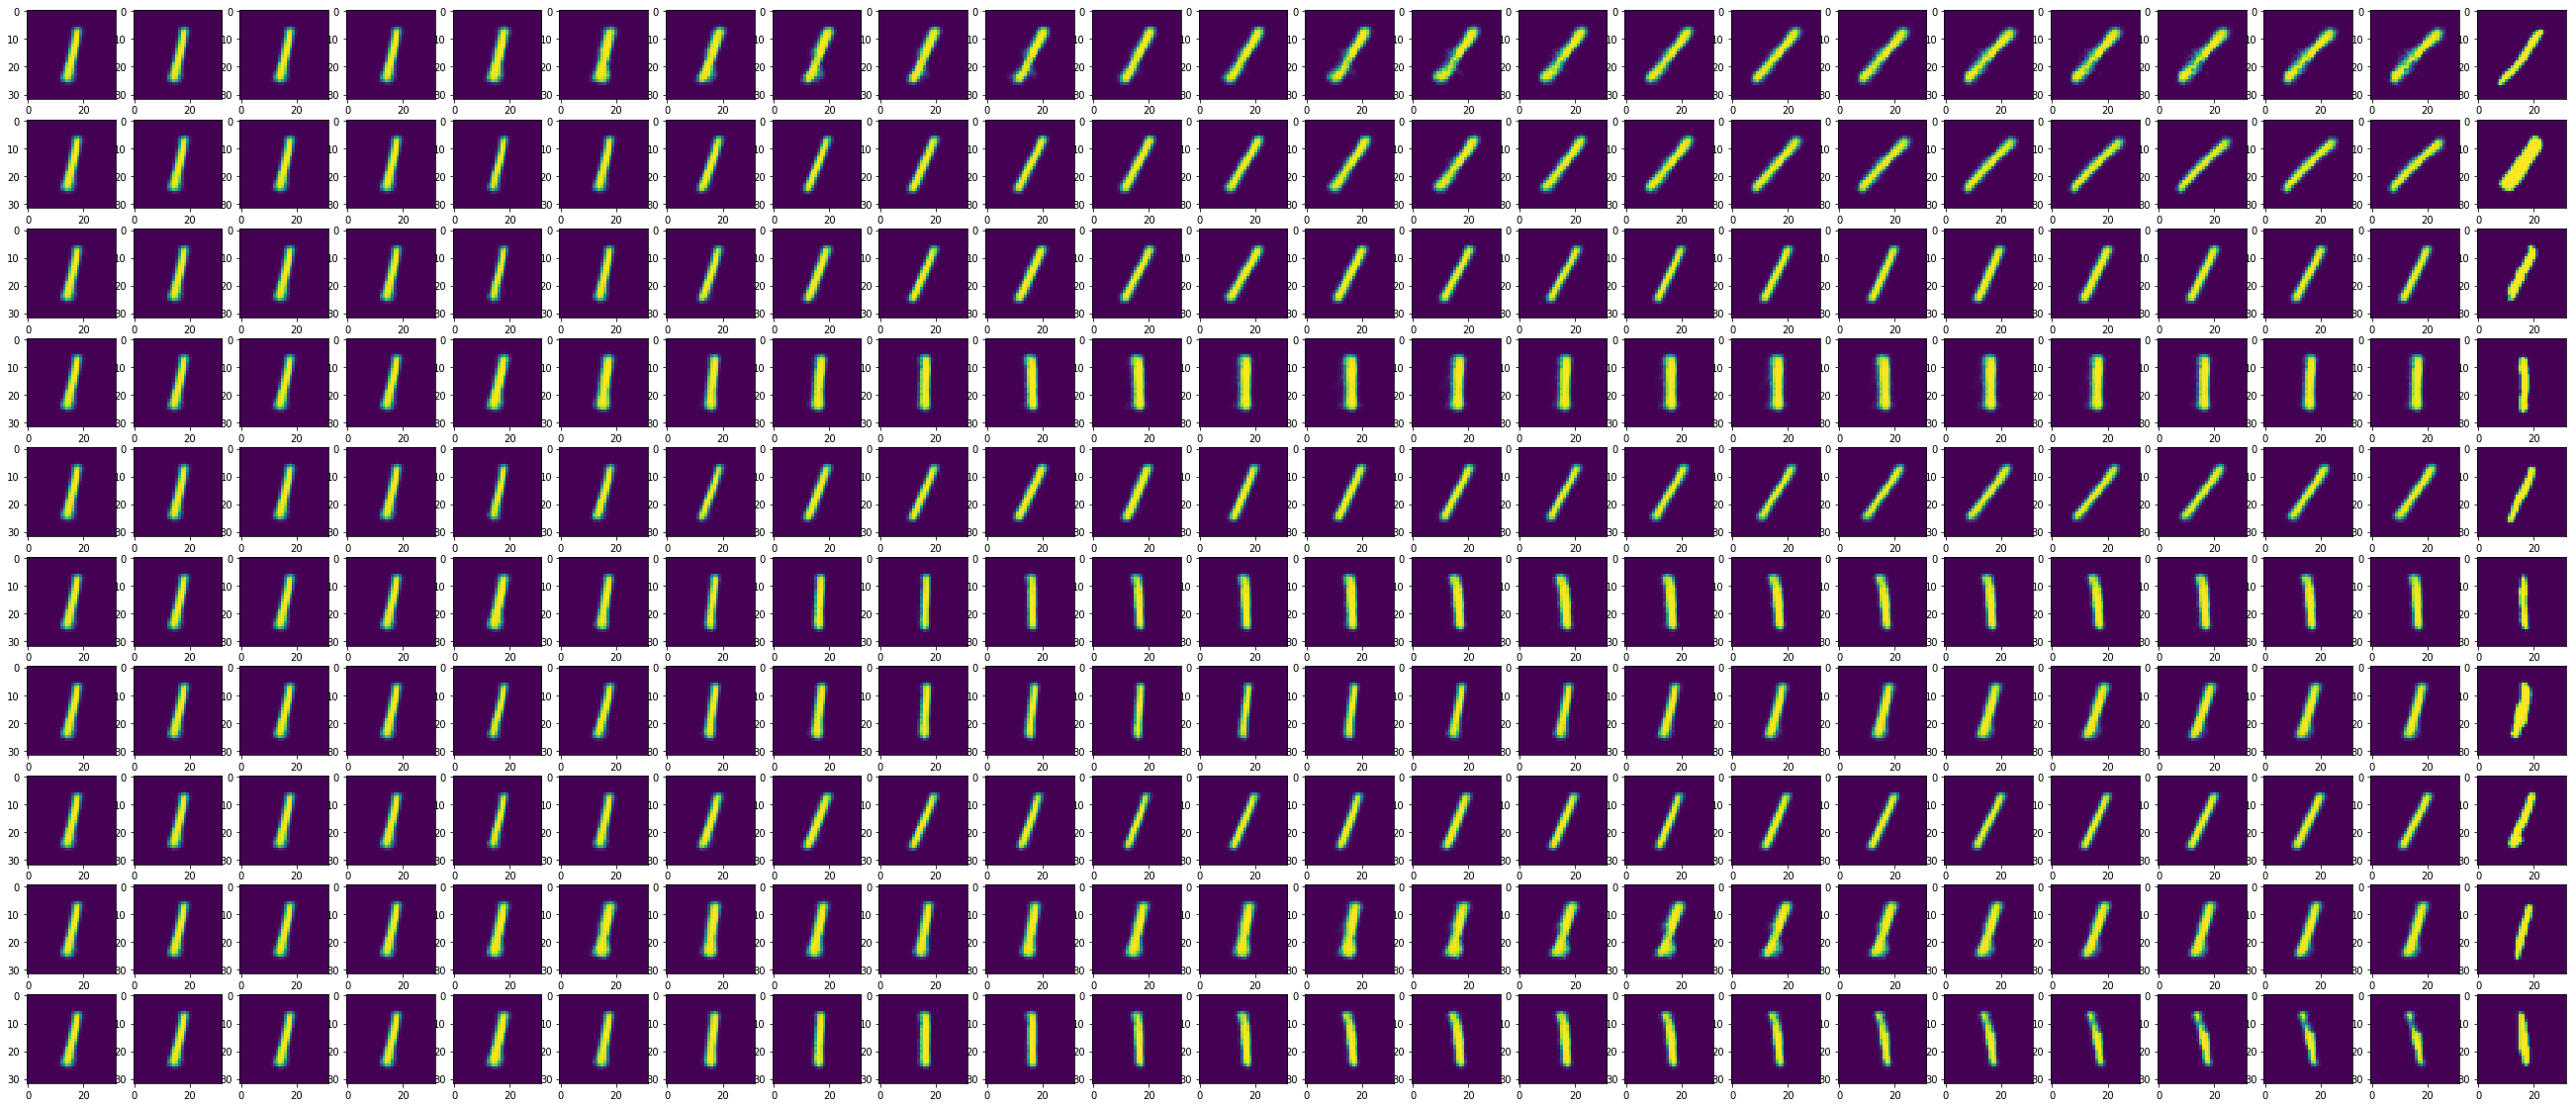

In [21]:
localization_plotting.save_localization_plots(model, data_manager, localizers)

Error: You must call wandb.init() before wandb.log()

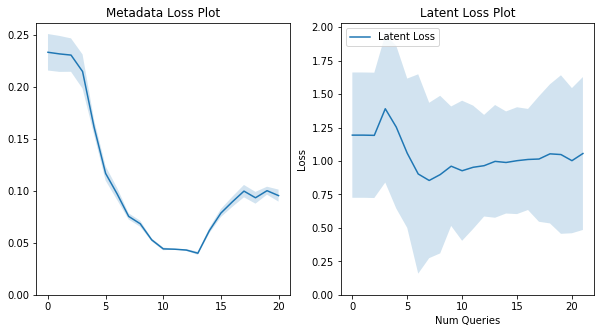

In [22]:
save_localization_metadata_distance_plots(localizer_metrics)
plt.show()

In [ ]:
# what is the standard deviation 

In [10]:
embedding = data_manager.get_latent_point_training(model)

In [ ]:
# plot posterior path
for localizer in localizers:
    y = np.ones(np.shape(embedding)[0])
    localization_plotting.embedding_with_posterior_path(embedding, y, localizer.posterior_means,reference_data=localizer.embedded_reference)
    plt.show()

In [80]:
# plot the final loss vs the k value


In [81]:
print("test")

test


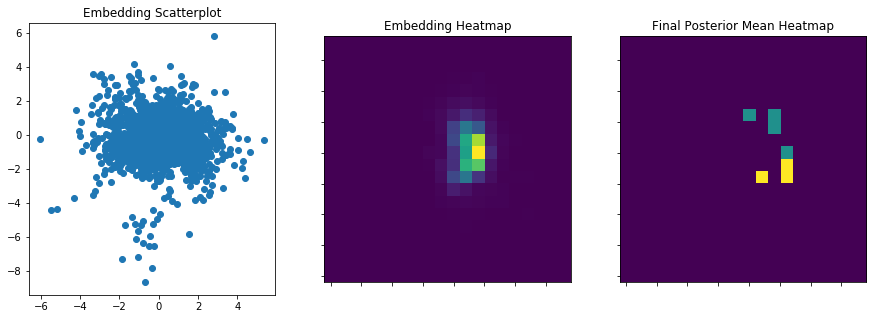

In [84]:
# plot the final locations as a heatmap
def plot_embedding_and_heatmap(embedding, localizers):
    # get the final posterior means 
    final_means = np.array([localizer.posterior_means[-1] for localizer in localizers])
    # make figure
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # ranges
    hist_max = np.amax(embedding, 0)
    hist_min = np.amin(embedding, 0)
    hist_range = [[hist_min[0], hist_max[0]], [hist_min[1], hist_max[1]]]
    # plot the embedding points
    axs[0].set_title("Embedding Scatterplot")
    axs[0].scatter(embedding[:, 0], embedding[:, 1])
    # plot the embedding distribution as a heatmap on the left side
    axs[1].set_yticklabels([])
    axs[1].set_xticklabels([])
    axs[1].set_title("Embedding Heatmap")
    hist, _, _ = np.histogram2d(embedding[:, 0], embedding[:, 1], bins=20, range=hist_range)
    axs[1].imshow(hist, cmap='viridis', interpolation='nearest', origin="lower")
    # plot the heatmap over the embedding space on the right side
    axs[2].set_yticklabels([])
    axs[2].set_xticklabels([])
    axs[2].set_title("Final Posterior Mean Heatmap")
    final_hist, _, _ = np.histogram2d(final_means[:, 0], final_means[:, 1], bins=20, range=hist_range)
    axs[2].imshow(final_hist, cmap='viridis', interpolation='nearest', origin="lower")
    # draw plot
    plt.show()
    
plot_embedding_and_heatmap(embedding, localizers)

In [68]:
# show a plot that shows the slant over the space 
# plot a feature heatmap
# also plot a 2d map of the distance in metadata space of a point from every other point in space
# see if points sampled around that point in space are similar to it
# see if there is a multimodal nature to the feature
# this may not happen for a single feature, but may be more likely if multiple features are used at the same time
# this is reflective of imperfect disentanglement of the metadata features
# if so sample points around that.
# Perform localization without randomness on the points in a certain region
# and see if the final locations of convergence coincide with the multiple regions of similarity 
# this may need to have randomness introduced to it. 

[[ 1.11569536  0.14503607]
 [-1.33792901 -0.54302686]
 [-0.91095304 -0.37148386]
 ...
 [ 0.93827397 -0.09392969]
 [ 1.50337601 -1.02266848]
 [ 1.09478509 -0.39853257]]


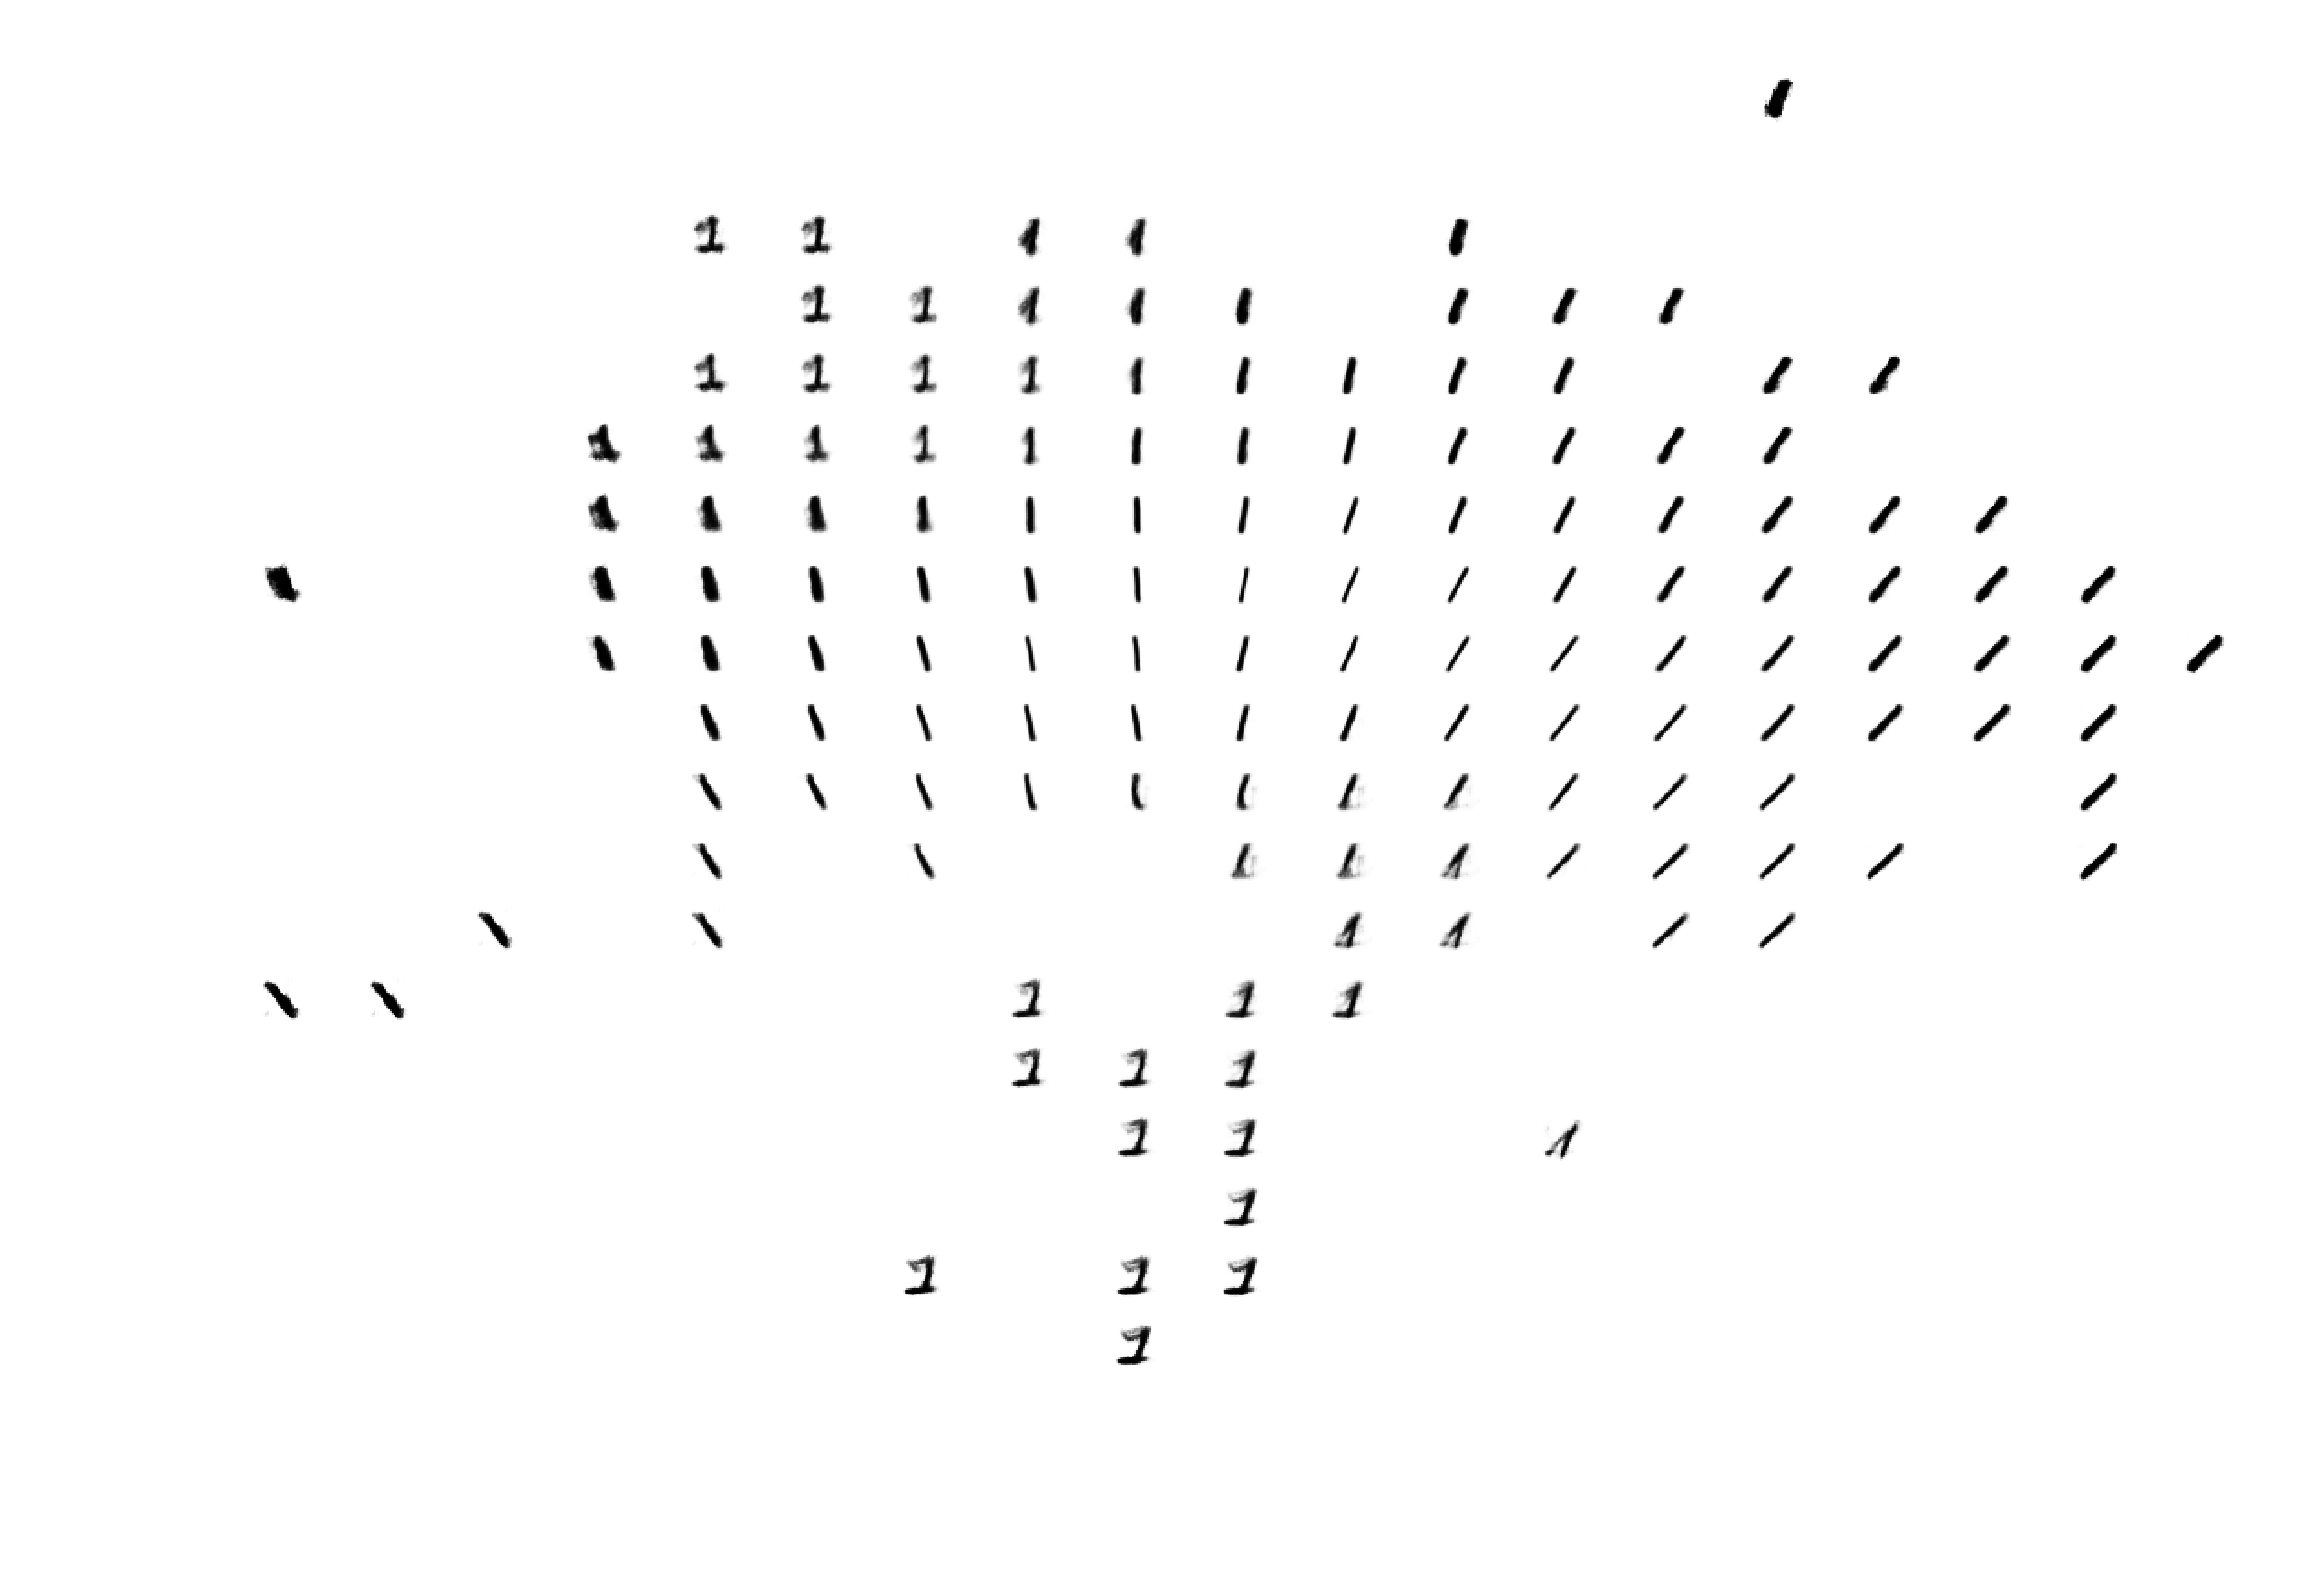

In [85]:
#plot image sampling
image_sampling.plot_binned_tsne_grid(embedding, embedding, model, num_channels=1, dpi=500, num_x_bins=20, num_y_bins=20, title="")
plt.show()

/home/alec/anaconda3/envs/latent/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


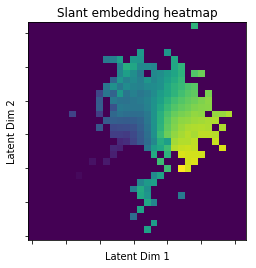

In [96]:
def feature_heatmap(embedding, feature=3, title=None, num_bins=30):
    # bin the embedding values with digitize
    _, bin_edges = np.histogram(embedding, bins=num_bins)
    binned_indices = np.digitize(embedding, bin_edges)
    # get the metadata value for each of the values in each of the bins
    mean_metadata_value = np.zeros((num_bins+2, num_bins+2))
    num_metadata_value = np.zeros((num_bins+2, num_bins+2))
    for i, bin_index in enumerate(binned_indices):
        metadata = metadata_dataset[i]
        mean_metadata_value[bin_index[0], bin_index[1]] += metadata[feature]
        num_metadata_value[bin_index[0], bin_index[1]] += 1
    
    mean_metadata_value /= num_metadata_value
    mean_metadata_value[np.isnan(mean_metadata_value)] = 0
    # calculate the mean metadata value for a region
    # plot with imshow a heatmap showing the feature value
    fig, ax = plt.subplots(1, 1)
    ax.imshow(mean_metadata_value.T, cmap="viridis", interpolation='nearest', origin="lower")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if not title is None:
        ax.set_title(title)
    else:
        ax.set_title("Slant embedding heatmap".format(feature))
    ax.set_ylabel("Latent Dim 2")
    ax.set_xlabel("Latent Dim 1")
    
feature_heatmap(embedding, feature=3)

/home/alec/anaconda3/envs/latent/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


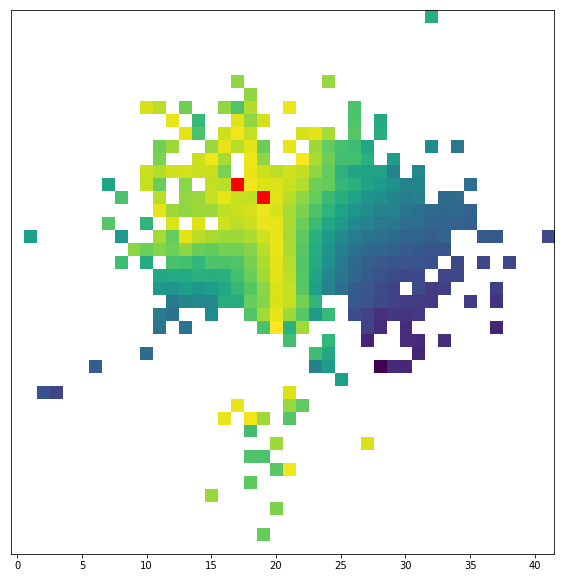

In [100]:
# plot a heatmap of the distance between two points in space using two features
num_bins=40
features = [3]
localizer_num = 5
# distance metric
def distance_metric(a, b, features):
    dist = np.linalg.norm(a[features] - b[features])
    return dist
# choose a random point in the embedding
# get index of reference image
# rand_index = np.random.randint(0, len(metadata_dataset))
embedded_reference_metadata = metadata_dataset.measure_image(localizers[localizer_num].reference_data)
# calculate the distance in metadata feature space between a point and every other point
dists = []
for i in range(np.shape(embedding)[0]):
    a = metadata_dataset[i]
    dist = distance_metric(a, embedded_reference_metadata, features)
    dists.append(dist)
# calculate the heatmap data
_, bin_edges_x, bin_edges_y = np.histogram2d(embedding[:, 0], embedding[:, 1], bins=num_bins)
bin_indices_x = np.digitize(embedding[:, 0], bin_edges_x)[None, :]
bin_indices_y = np.digitize(embedding[:, 1], bin_edges_y)[None, :]
binned_indices = np.concatenate((bin_indices_x, bin_indices_y), axis=0).T
# get the metadata value for each of the values in each of the bins
mean_distance_value = np.zeros((num_bins+2, num_bins+2))
num_distance_value = np.zeros((num_bins+2, num_bins+2))
for i, bin_index in enumerate(binned_indices):
    distance = dists[i]
    mean_distance_value[bin_index[0], bin_index[1]] += distance
    num_distance_value[bin_index[0], bin_index[1]] += 1

mean_distance_value /= num_distance_value
mean_distance_value[np.isnan(mean_distance_value)] = -1
# get chosen rand_index bin 
# get location of embedded reference
embedded_reference = localizers[localizer_num].embedded_reference
embedded_reference_index_x = np.digitize([embedded_reference[0]], bin_edges_x)[None, :]
embedded_reference_index_y = np.digitize([embedded_reference[1]], bin_edges_y)[None, :]

cmap = plt.cm.viridis_r
cmap.set_bad((1, 0, 0, 1))
cmap.set_under((1, 1, 1, 1))
mean_distance_value[embedded_reference_index_x, embedded_reference_index_y] = np.nan
final_posterior_mean = localizers[localizer_num].posterior_means[-1]
final_posterior_x = np.digitize([final_posterior_mean[0]], bin_edges_x)[None, :]
final_posterior_y = np.digitize([final_posterior_mean[1]], bin_edges_y)[None, :]
mean_distance_value[final_posterior_x, final_posterior_y] = np.nan
# show that as a heatmap
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.set_yticks([])
axs.set_yticks([])
#mean_distance_value = np.fliplr(mean_distance_value)
axs.imshow(mean_distance_value.T, cmap=cmap, origin="lower", vmin=0)

NameError: name 'embedding' is not defined

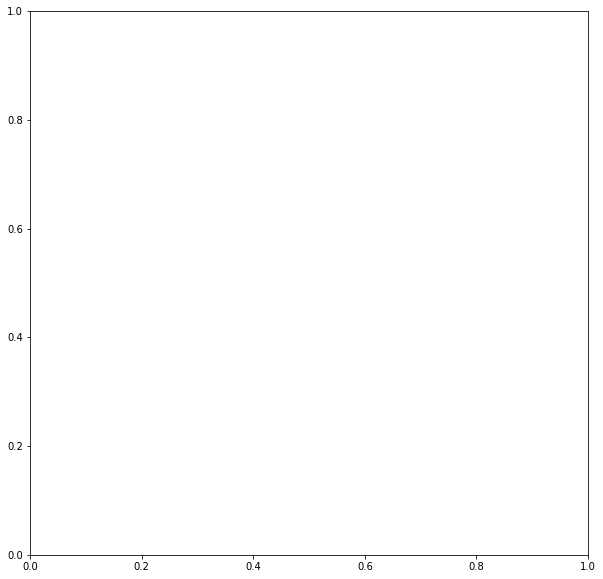

In [8]:
# plot the path of convergance towards a reference point 
# are there some points that are inaccesible
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
embedding_with_posterior_path(
    embedding, 
    ["." for i in range(np.shape(embedding)[0])], 
    localizers[localizer_num].posterior_means,
    ax=axs, 
    reference_data=localizers[localizer_num].embedded_reference,
    bounds=[min(bin_edges_x), max(bin_edges_x), min(bin_edges_y), max(bin_edges_y)]
)
plt.show()

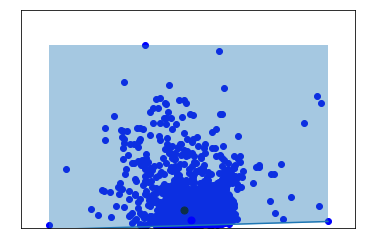

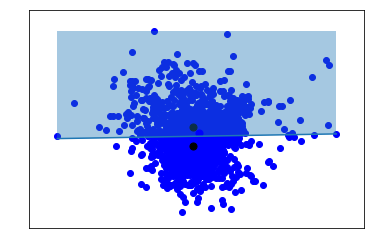

In [139]:
# take a query and the hyperplane. Sample all items in the embedding and make a heatmap 
# of the probability ot items in a certain region of satisfying the query properties
# randomly select two points in the embedding space
# draw a hyperplane 
# embedding with hyperplane
embedding_index_a = np.random.randint(np.shape(embedding)[0])
embedding_index_b = np.random.randint(np.shape(embedding)[0])
queries = [[embedding[embedding_index_a], embedding[embedding_index_b]]]
query_responses = [1]
# get query hyperplane
a, tau = pair2hyperplane([embedding_index_a, embedding_index_b], embedding, KNormalizationType.NORMALIZED)
# calculate is on left side of plane
#new_queries = queries + a*tau
new_embedding = []
for val in embedding:
    # which side
    dot_prod = np.dot(a, val - a*tau)
    if dot_prod > 0:
        new_embedding.append(val)
new_embedding = np.array(new_embedding)
# go through each point
embedding_with_planes(new_embedding, new_embedding, queries, query_responses, mode="linear_projected", variance=np.array([[0, 0], [0, 0]]), current_estimate=np.array([0, 0]))
plt.show()
# if dot product is positive with vector
embedding_with_planes(embedding, embedding, queries, query_responses, mode="linear_projected", variance=np.array([[0, 0], [0, 0]]), current_estimate=np.array([0, 0]))
plt.show()

/home/alec/anaconda3/envs/latent/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


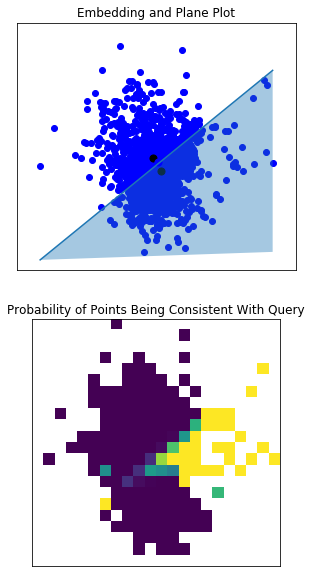

In [155]:
embedding_index_a = np.random.randint(np.shape(embedding)[0])
embedding_index_b = np.random.randint(np.shape(embedding)[0])
a_metadata = metadata_dataset[embedding_index_a] 
b_metadata = metadata_dataset[embedding_index_b]
queries = [[embedding[embedding_index_a], embedding[embedding_index_b]]]
query_responses = [1]
# get query hyperplane
a, tau = pair2hyperplane([embedding_index_a, embedding_index_b], embedding, KNormalizationType.NORMALIZED)
# go through each point
is_consistent_list = []
for i in range(len(metadata_dataset)):
    embedding_val = embedding[i]
    metadata_val = np.array(metadata_dataset[i])[3]
    # see if point is on side
    dot_prod = np.dot(a, embedding_val - a*tau)
    positive = dot_prod > 0
    # see which query metadata_val is closer
    dist_a = np.linalg.norm(a_metadata - metadata_val)
    dist_b = np.linalg.norm(b_metadata - metadata_val)
    closer_metadata = 0 if dist_a < dist_b else 1
    # metadata is closer 
    is_consistent = closer_metadata == 0 and positive or closer_metadata == 1 and not positive
    is_consistent_list.append(is_consistent)

# calculate the heamap
cmap = plt.cm.viridis_r
num_bins = 20
_, bin_edges_x, bin_edges_y = np.histogram2d(embedding[:, 0], embedding[:, 1], bins=num_bins)
bin_indices_x = np.digitize(embedding[:, 0], bin_edges_x)[None, :]
bin_indices_y = np.digitize(embedding[:, 1], bin_edges_y)[None, :]
binned_indices = np.concatenate((bin_indices_x, bin_indices_y), axis=0).T
# get the metadata value for each of the values in each of the bins
mean_distance_value = np.zeros((num_bins+2, num_bins+2))
num_distance_value = np.zeros((num_bins+2, num_bins+2))
for i, bin_index in enumerate(binned_indices):
    is_consistent = is_consistent_list[i]
    mean_distance_value[bin_index[0], bin_index[1]] += is_consistent
    num_distance_value[bin_index[0], bin_index[1]] += 1
mean_distance_value /= num_distance_value
# mean_distance_value[np.isnan(mean_distance_value)] = -1
# plot the heatmap
fig, axs = plt.subplots(2, 1, figsize=(5, 10))
plt.title("Query Consistency")
axs[0].set_title("Embedding and Plane Plot")
axs[0].set_yticks([])
axs[0].set_xticks([])
embedding_with_planes(embedding, embedding, queries, query_responses, mode="linear_projected", variance=np.array([[0, 0], [0, 0]]), current_estimate=np.array([0, 0]), axis=axs[0])

axs[1].set_title("Probability of Points Being Consistent With Query")
axs[1].set_yticks([])
axs[1].set_xticks([])
#mean_distance_value = np.fliplr(mean_distance_value)
axs[1].imshow(mean_distance_value.T, cmap=cmap, origin="lower", vmin=0)
plt.show()

In [ ]:
# plot a heatmap of the distance between two points in space using two features
num_bins=40
features = [3]
localizer_num = 5
# distance metric
def distance_metric(a, b, features):
    dist = np.linalg.norm(a[features] - b[features])
    return dist
# choose a random point in the embedding
# get index of reference image
# rand_index = np.random.randint(0, len(metadata_dataset))
embedded_reference_metadata = metadata_dataset.measure_image(localizers[localizer_num].reference_data)
# calculate the distance in metadata feature space between a point and every other point
dists = []
for i in range(np.shape(embedding)[0]):
    a = metadata_dataset[i]
    dist = distance_metric(a, embedded_reference_metadata, features)
    dists.append(dist)
# calculate the heatmap data
_, bin_edges_x, bin_edges_y = np.histogram2d(embedding[:, 0], embedding[:, 1], bins=num_bins)
bin_indices_x = np.digitize(embedding[:, 0], bin_edges_x)[None, :]
bin_indices_y = np.digitize(embedding[:, 1], bin_edges_y)[None, :]
binned_indices = np.concatenate((bin_indices_x, bin_indices_y), axis=0).T
# get the metadata value for each of the values in each of the bins
mean_distance_value = np.zeros((num_bins+2, num_bins+2))
num_distance_value = np.zeros((num_bins+2, num_bins+2))
for i, bin_index in enumerate(binned_indices):
    distance = dists[i]
    mean_distance_value[bin_index[0], bin_index[1]] += distance
    num_distance_value[bin_index[0], bin_index[1]] += 1

mean_distance_value /= num_distance_value
mean_distance_value[np.isnan(mean_distance_value)] = -1
# get chosen rand_index bin 
# get location of embedded reference
embedded_reference = localizers[localizer_num].embedded_reference
embedded_reference_index_x = np.digitize([embedded_reference[0]], bin_edges_x)[None, :]
embedded_reference_index_y = np.digitize([embedded_reference[1]], bin_edges_y)[None, :]

cmap = plt.cm.viridis_r
cmap.set_bad((1, 0, 0, 1))
cmap.set_under((1, 1, 1, 1))
mean_distance_value[embedded_reference_index_x, embedded_reference_index_y] = np.nan
final_posterior_mean = localizers[localizer_num].posterior_means[-1]
final_posterior_x = np.digitize([final_posterior_mean[0]], bin_edges_x)[None, :]
final_posterior_y = np.digitize([final_posterior_mean[1]], bin_edges_y)[None, :]
mean_distance_value[final_posterior_x, final_posterior_y] = np.nan
# show that as a heatmap
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.set_yticks([])
axs.set_yticks([])
#mean_distance_value = np.fliplr(mean_distance_value)
axs.imshow(mean_distance_value.T, cmap=cmap, origin="lower", vmin=0)
plt.show()

In [19]:
# sample a bunch of queries, measure the percentage of points that are consistent with the query
# make a histogram of the average based on the location of the query midpoint
num_queries = 3000
midpoints = []
percent_consistent = []
for query_num in tqdm(range(num_queries)):
    # randomly generate a query  
    embedding_index_a = np.random.randint(np.shape(embedding)[0])
    embedding_index_b = np.random.randint(np.shape(embedding)[0])
    a_metadata = metadata_dataset[embedding_index_a] 
    b_metadata = metadata_dataset[embedding_index_b]
    queries = [[embedding[embedding_index_a], embedding[embedding_index_b]]]
    midpoint = 1/2*(embedding[embedding_index_a] + embedding[embedding_index_b])
    midpoints.append(midpoint)
    query_responses = [1]
    # get query hyperplane
    a, tau = pair2hyperplane([embedding_index_a, embedding_index_b], embedding, KNormalizationType.NORMALIZED)
    # go through each point and see if it is consistent
    total = 0
    num_consistent = 0
    for i in range(len(metadata_dataset)):
        embedding_val = embedding[i]
        metadata_val = np.array(metadata_dataset[i])[3]
        # see if point is on side
        dot_prod = np.dot(a, embedding_val - a*tau)
        positive = dot_prod > 0
        # see which query metadata_val is closer
        dist_a = np.linalg.norm(a_metadata - metadata_val)
        dist_b = np.linalg.norm(b_metadata - metadata_val)
        closer_metadata = 0 if dist_a < dist_b else 1
        # metadata is closer 
        is_consistent = closer_metadata == 0 and positive or closer_metadata == 1 and not positive
        total += 1
        if is_consistent:
            num_consistent += 1
            
    percent_consistent.append(num_consistent/total)
midpoints = np.array(midpoints)
percent_consistent = np.array(percent_consistent)

100%|██████████| 3000/3000 [04:37<00:00, 10.81it/s]


In [ ]:
print("done")

/home/alec/anaconda3/envs/latent/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


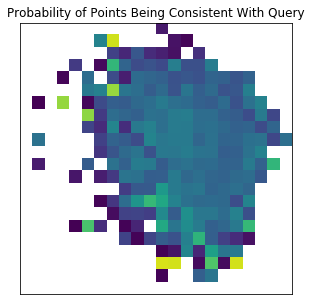

In [20]:
# calculate the heamap
cmap = plt.cm.viridis_r
num_bins = 20
_, bin_edges_x, bin_edges_y = np.histogram2d(midpoints[:, 0], midpoints[:, 1], bins=num_bins)
bin_indices_x = np.digitize(midpoints[:, 0], bin_edges_x)[None, :]
bin_indices_y = np.digitize(midpoints[:, 1], bin_edges_y)[None, :]
binned_indices = np.concatenate((bin_indices_x, bin_indices_y), axis=0).T
# get the metadata value for each of the values in each of the bins
mean_consistency_percentage = np.zeros((num_bins+2, num_bins+2))
num_per_bin = np.zeros((num_bins+2, num_bins+2))
for i, bin_index in enumerate(binned_indices):
    percent = percent_consistent[i]
    mean_consistency_percentage[bin_index[0], bin_index[1]] += percent
    num_per_bin[bin_index[0], bin_index[1]] += 1
mean_consistency_percentage /= num_per_bin
print(num_per_bin)
# mean_distance_value[np.isnan(mean_distance_value)] = -1
# plot the heatmap
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.set_title("Probability of Points Being Consistent With Query")
axs.set_yticks([])
axs.set_xticks([])
axs.imshow(mean_consistency_percentage.T, cmap=cmap, origin="lower", vmin=0)
plt.show()

In [21]:
print()

0.6471816473845545


In [23]:
np.mean(percent_consistent)

1.5451612449785697

In [ ]:
# is metadata measurement deterministic
# choose a random image
image = image_data[0]
mean, _ = model.encode(image)
print(mean)
image = image.squeeze()
# get mesurements
measurements = []
for i in range(10):
    measurement = list(measure_image(image))
    measurements.append(measurement)
measurements = np.array(measurements)
print(measurements)
# if not what is the standard deviation